# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-20 20:26:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [  <=>               ] 201.24M  26.8MB/s    in 8.5s    

2023-10-20 20:26:54 (23.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandardScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(666)

In [8]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
model = Ridge().fit(X_train, y_train)
train_result = mse(y_train, model.predict(X_train), squared=False)
test_result = mse(y_test, model.predict(X_test), squared=False)

print (f'''train result: {train_result}
test result: {test_result}''')

train result: 9.552822967970322
test result: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
const = y_train.mean()
y_const = np.tile(const, y_test.shape[0])
best_rmse_metric = mse(y_test, y_const, squared=False)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!

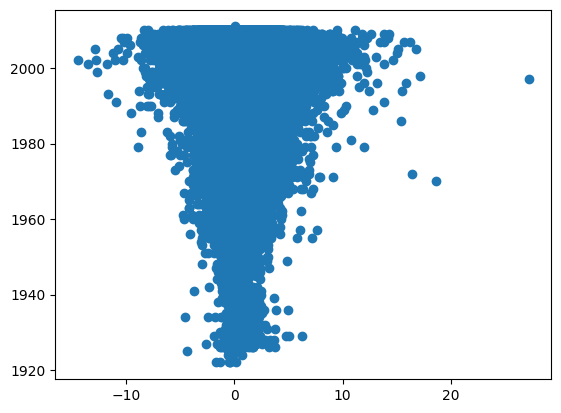

In [13]:
plt.scatter(X_train[:, -1], y_train)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses):
    clear_output()
    fig, axs = plt.subplots(1, 1, figsize=(13, 4))
    axs.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs.plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs.set_ylabel('loss')
    axs.set_xlabel('epoch')
    axs.legend()

    plt.show()

In [12]:
class LinearRegression():
  def __init__(self, lr, n_estimators):
      self.w = torch.tensor(1., requires_grad=True)
      self.b = torch.tensor(1., requires_grad=True)
      self.losses = []

      self.lr = lr
      self.n_estimators = n_estimators

  def fit(self, X, y):
      self.X = torch.tensor(X_train[:, -1], dtype=torch.float32)
      self.y = torch.tensor(y_train, dtype=torch.float32)
      self.m, self.n = X.shape

      # здесь можно написать GD
      for iteration in range(self.n_estimators):
          y_pred = self.w * self.X + self.b
          loss = torch.sqrt(torch.mean((y_pred - self.y) ** 2))
          self.losses.append(loss)
          loss.backward()
          self.w.data -= self.lr * self.w.grad
          self.b.data -= self.lr * self.b.grad
          self.w.grad.data.zero_(), self.b.grad.data.zero_()

  def predict(self, X):
    X = torch.tensor(X, dtype=torch.float32)
    return torch.mul(X, self.w).add(self.b)


In [14]:
n_estimators = list(range(300, 501, 100))
lr = [1, 10, 100]
best_loss = float('inf')
best_iter, best_lr = 0, 0

for i in lr:
    for j in n_estimators:
        model = LinearRegression(i, j)
        for epoch in range(1, 11):
          model.fit(X_train, y_train)
          # Prediction on test set
          y_pred = model.predict(X_test)
          if model.losses[-1] < best_loss:
              best_loss = model.losses[-1]
              best_lr, best_iter = i, j

In [15]:
best_loss, best_lr, best_iter

(tensor(10.9227, grad_fn=<SqrtBackward0>), 1, 300)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [18]:
!pip install wandb --upgrade --quiet

In [19]:
from tqdm.auto import tqdm
import wandb
!wandb login()

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `wandb login()'


In [20]:
scaler = StandardScaler(with_mean=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler(with_mean=True)
y_train = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = target_scaler.transform(y_test.reshape(-1, 1))

In [36]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            torch.nn.Linear(90, 64),
            # torch.nn.BatchNorm1d(64, affine=True),
            # torch.nn.Dropout(0, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            # torch.nn.BatchNorm1d(64, affine=True),
            # torch.nn.Dropout(0, 4),
            torch.nn.ReLU(), # torch.nn.LeakyReLU(negative_slope=0.01, inplace=False) ??
            torch.nn.Linear(64, 1)
        )

    def forward(self, X):
        return self.model(X)

In [22]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.078786,0.391566,1.826962,0.466361,-0.476621,-0.275266,-1.551924,-1.311105,0.389093,-0.665402,...,-0.084995,0.106413,0.144257,-0.236180,0.047430,-0.355855,0.544084,-0.470477,-0.255366,0.042637
1,0.879511,0.332631,1.748961,0.723345,-0.166769,-1.189729,0.764797,0.109714,1.422683,0.416934,...,-0.314004,0.304413,-0.068758,0.053729,-0.634467,-0.435794,0.556059,0.570861,0.209341,1.161118
2,1.245515,0.592771,1.337550,0.752153,-0.002899,-0.699856,-0.061323,-0.069912,1.167910,-0.073176,...,-0.395974,0.565220,-0.758259,-0.282931,-0.026058,0.223918,-0.508889,-0.338081,0.107828,-0.090122
3,0.799787,-0.061214,0.784000,0.089197,0.327463,-1.297159,0.509977,-1.073557,-0.015553,-1.262565,...,0.586855,-0.562444,-0.479423,-0.890199,-0.796124,0.568335,-0.262505,0.409924,0.973205,0.795200
4,1.247663,0.793377,1.657449,0.449177,-0.408652,-0.564673,-0.692545,-0.952369,0.843389,-0.143557,...,-0.181284,0.097564,0.192974,-0.585048,-0.113758,-0.219524,0.448546,0.258400,0.194381,1.244057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463710,0.492756,-0.335549,-0.084459,-0.656073,-1.675351,0.285865,-1.493532,-0.686944,0.832549,-1.057817,...,0.124674,0.990884,-0.324914,-0.394720,1.530260,0.085898,-0.001212,-0.322543,-0.617490,-0.698879
463711,-0.124305,0.200903,-0.926062,-0.894906,-1.645646,-0.372671,0.621834,-0.478465,0.760305,-1.016607,...,-0.371914,1.868821,-0.550887,-0.651741,2.409392,0.031123,-1.187413,-0.119730,0.471477,-0.343674
463712,0.162956,0.007057,0.836966,0.069338,-0.368921,0.277246,-2.079127,-0.029297,-0.220203,-0.721385,...,-0.102787,0.438779,-0.407079,-0.822190,0.863293,-0.687453,-0.265296,-0.663950,0.014553,-0.246412
463713,0.247032,0.249674,-0.407125,-1.275544,-2.292766,-0.370757,-0.105394,0.164310,-0.144972,0.032255,...,0.367707,1.480623,0.128418,-0.701047,1.255686,0.638535,0.343939,0.534925,0.469997,0.702437


In [37]:
NUM_EPOCH = 26

train_set = torch.utils.data.TensorDataset(torch.from_numpy(X_train.astype(np.float32)),
                                           torch.from_numpy(y_train.astype(np.float32)))
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True,
                                           batch_size=64)

test_set = torch.utils.data.TensorDataset(torch.from_numpy(X_test.astype(np.float32)),
                                          torch.from_numpy(y_test.astype(np.float32)))

# Батч приравнял к шэйпу теста, чтобы избежать Assertion Error
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False,
                                          batch_size=y_test.shape[0])

model = Model()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
# SGD, Rprop, RMSprop, RAdam, NAdam, LBFGS, ASGD, Adamax, SparseAdam, AdamW, Adam, Adagrad, Adadelta
scheduler = scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH)
criterion = nn.MSELoss()

In [ ]:
next(iter(tqdm(train_loader)))

In [26]:
def train(model, optimizer, criterion,
          train_loader, test_loader,
          n_epochs, scheduler, wandb_project=None):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    set_random_seed(666)
    train_losses, test_losses = [], []
    # подключаем wandb
    if wandb_project:
        import wandb
        # логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
        wandb.login()
        # инициализируем проект
        wandb.init(project="ida_dl_hw1", entity='your_masya',
                   settings=wandb.Settings(start_method="fork"))
        # сохраняем параметры сетки в wandb + просим следить за градиентами сетки
        wandb.watch(model);
        # wandb.finish()

    for epoch in range(1, n_epochs + 1):
        train_loss = []
        # тренировка
        for x_train, y_train in tqdm(train_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # тут таргет и предсказание обратно масштабируются,
            # считается лосс и добавляется в список для подсчета среднего
            model.eval()
            train_loss.append(criterion(torch.tensor(target_scaler.inverse_transform(model(x_train).detach().numpy())),
                                        torch.tensor(target_scaler.inverse_transform(y_train))))
            model.train()

        if scheduler is not None:
            scheduler.step()

        # валидация
        if epoch:
            test_loss = []
            # отключается весь функционал расчета градиентов
            model.eval()
            with torch.no_grad():
                for x_val, y_val in tqdm(test_loader):
                    y_pred = model(x_val)
                    test_loss.append(criterion(
                        torch.tensor(target_scaler.inverse_transform(y_pred)),
                        torch.tensor(target_scaler.inverse_transform(y_val))))

            model.train()
            train_losses.append(np.sqrt(np.mean(train_loss)))
            test_losses.append(np.sqrt(np.mean(test_loss)))

            if wandb_project:
                wandb.log(
                    {'Train Loss': np.mean(train_loss[-1].detach().numpy()),
                     'Test loss': np.mean(test_loss[-1].detach().numpy())}
                )

            # печатаем метрики
            print(
                f'''Epoch: {epoch}, train loss: {train_losses[-1]}
                    Epoch: {epoch}, test loss: {test_losses[-1]}'''
            )
    plot_losses(train_losses, test_losses)

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    set_random_seed(666)
    model.eval()
    with torch.no_grad():
        losses = []
        for x_val, y_val in tqdm(test_loader):
            predicts = model(x_val)
            losses.append(criterion(torch.tensor(target_scaler.inverse_transform(predicts)),
                                    torch.tensor(target_scaler.inverse_transform(y_val))))

    print(f'Loss: {np.sqrt(np.mean(losses))}')
    model.train()
    return predicts


In [ ]:
# модель с батчами и без дропаутов

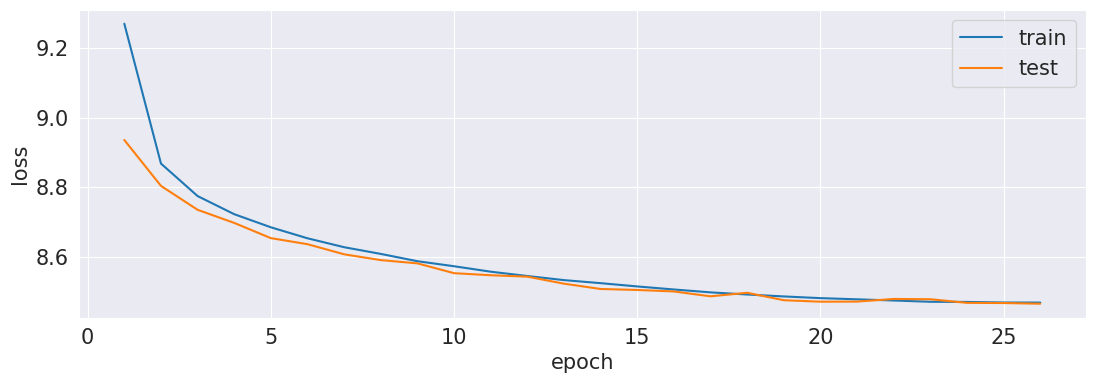

In [34]:
print(
    f"Training model with AdamW optimiztion and {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer, criterion,
      train_loader, train_loader, NUM_EPOCH, scheduler, None)

In [ ]:
# Loss < 8.75 ???

In [35]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 8.795779378422525


In [ ]:
# Модель без батчей и дропаутов.

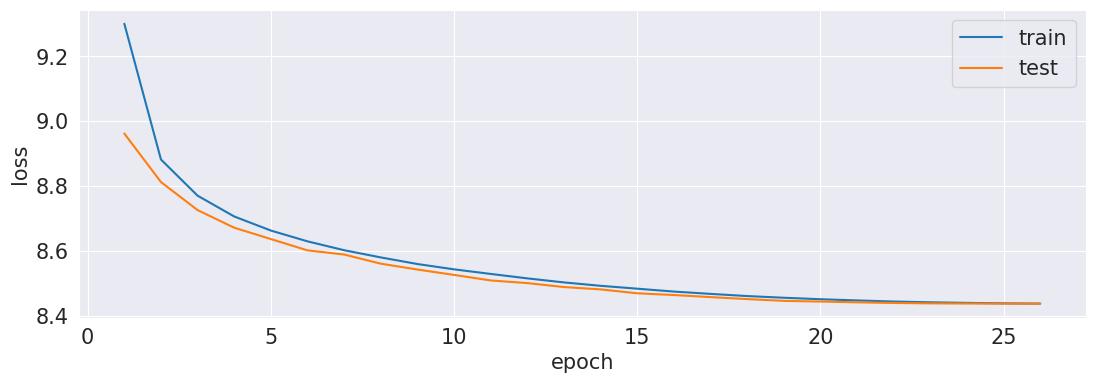

In [38]:
print(
    f"Training model with AdamW optimiztion and {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer, criterion,
      train_loader, train_loader, NUM_EPOCH, scheduler, None)

In [39]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 8.796430269846956


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

## **Эксперимент 1**

Изначально было принято решение нормировать данные, так как ошибка без данной манипуляции была слишком высокой. Были опробованы MaxAbsScaler, MinMaxScaler & StandardScaler из sklearn. Наибольший прирост качества показал StandardScaler, и поэтому работу решено было продолжить именно с ним.

## **Эксперимент 2**

Далее были попытки подобрать ширину и кол-во полносвязных слоёв. Выставление кол-ва признаков на выход > вход приводило к снижению качества. Пробовал делать 8 слоёв с плавно убывающим кол-вом признаков, но это также не дало значимых улучшений. Сначала это не давало результатов, но потом оказалось, что такая сеть достаточно неплохо уменьшает ошибку. В итоге я пришёл к 3 полносвязным слоям. Но ошибка также оставалась чуть выше 10. Тогда я внедрил батчнорм и дропаут (вместе, понимаю, что это не совсем корректно, лучше такие изменения добавлять по 1), что очень сильно улучшило результаты. На тесте стал получать результат < 9.

## **Эксперимент 3**

Отсутствие коэффициента регуляризации приводило к переобучению модели, в то время как высокие значения lr не позволяли нормально оптимизироваться. Методом проб и ошибок пришёл к lr = 0.0001. Также использовал параметр weight_decay = 0.01, чтобы снизить вероятность переобучения. Почти сразу отказался от использования SGD, обратив внимание на варианты с инерцией и масштабированием градиента. Наибольший прирост на данном этапе дал AdamW, его и оставил в итоговой модели.

## **Эксперимент 4**

Была попытка заменить Relu на LeakyRelu, но это только понизило качество, несмотря на интересное свойство у второй, заключающееся в том, что производная везде больше нуля, т.е функция учитывает те значения которые Relu зануляет. Добавлял дополнительный слой дропаута, буст был минимален, мб даже это можно списать на погрешность. Использовал косинусную функцию для шедулера, также заметил небольшие улучшения.

## **Эксперимент 5**


Экспериментировал с кол-вом эпох. На разных этапах работы приходилось ставить то меньше, то больше. 12-15 на начальных этапах давали больший прирост. По мере добавления оптимизаций, шедулеров и экспериментов с гиперпараметрами доходил до 30. Но в конечном итоге увидел, что после 26 эпохи начинается небольшой, но критичный рост на тесте, в связи с чем уменьшил кол-во эпох до 26. Также небольшой прирост дало ИЗБАВЛЕНИЕ ОТ БАТЧНОРМА и ДРОПАУТА, которые давали ощутимый буст на более ранних этапах работы.